In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm
import os
from PIL import Image
from tqdm import tqdm
import pandas as pd

/home/chep_workstation/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/chep_workstation/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/chep_workstation/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
img_size = 32
num_images_per_class = 10000
min_energy = 1
max_energy = 100

In [ ]:
def map_energy_to_color(energy_data, cmap="hot_r"):
    """Maps energy values to colors using a colormap."""
    normed_data = (energy_data - energy_data.min()) / (energy_data.max() - energy_data.min())
    cm = plt.get_cmap(cmap)
    colored_data = (cm(normed_data) * 255).astype(np.uint8)
    return colored_data

def generate_jet(center=None, width=img_size // 12, sparsity=0.1):
    x = np.linspace(-img_size//2, img_size//2, img_size)
    y = np.linspace(-img_size//2, img_size//2, img_size)
    x, y = np.meshgrid(x, y)

    if center is None:
        center = (np.random.randint(-img_size//4, img_size//4), np.random.randint(-img_size//4, img_size//4))

    z = np.exp(-((x-center[0])**2 + (y-center[1])**2) / (2*width**2))
    z = z * np.random.uniform(0.5, 5)  # Random strength

    # Introduce sparsity
    mask = np.random.rand(img_size, img_size) > sparsity
    z[mask] = 0

    return z

def generate_image(label):
    if label == "signal":
        jet1 = generate_jet(center=(-img_size//20, 0))
        jet2 = generate_jet(center=(img_size//20, 0))
        img_data = jet1 + jet2
    else:
        img_data = generate_jet(center=(0, 0))

    # Scale data to represent energy between min_energy and max_energy
    img_data = img_data / img_data.max() * (max_energy - min_energy) + min_energy
    img_data_colored = map_energy_to_color(img_data)
    return Image.fromarray(img_data_colored)


# Generate Images
for label in ["signal", "background"]:
    os.makedirs(f"./data_resnet/{label}", exist_ok=True)
    for i in range(num_images_per_class):
        if (i%100==0):
            print(i)
        img = generate_image(label)
        img.save(f"./data_resnet/{label}/{i}.png")


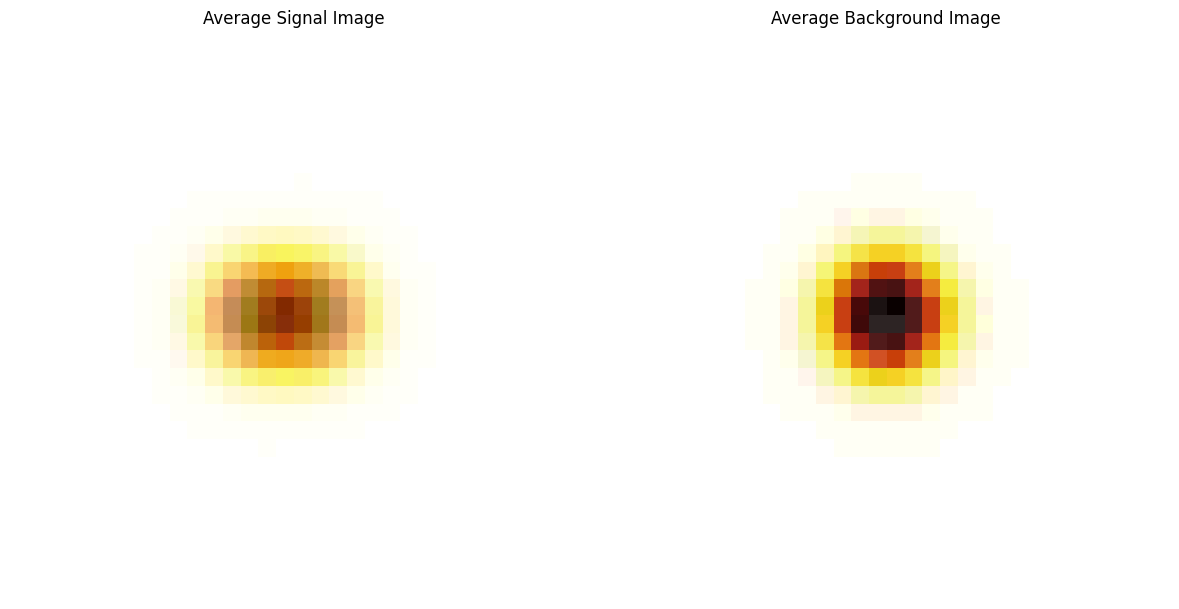

In [3]:
import matplotlib.pyplot as plt

def compute_average_image(label, num_images=num_images_per_class):
    total_image_data = np.zeros((img_size, img_size, 4), dtype=np.float32)
    for i in range(num_images):
        img_path = f"./data_resnet/{label}/{i}.png"
        img_data = np.array(Image.open(img_path))
        total_image_data += img_data
    average_image_data = (total_image_data / num_images).astype(np.uint8)
    avg_image = (average_image_data - average_image_data.min()) / (average_image_data.max() - average_image_data.min())
    return avg_image



# Compute average images for signal and background
avg_signal_image = compute_average_image("signal")
avg_background_image = compute_average_image("background")

# Plot the averages
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(avg_signal_image)
axes[0].set_title('Average Signal Image')
axes[0].axis('off')

axes[1].imshow(avg_background_image)
axes[1].set_title('Average Background Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()
